# Music Genre Classification
In this project we are going to use a CNN to classify music genre.
This is a free implementation of [this](https://medium.com/@juliendespois/finding-the-genre-of-a-song-with-deep-learning-da8f59a61194#.yhemoyql0) article. 

We need to turn music into spectrograms, we will use librosa in order to do so.

In [2]:
import librosa as lb

In [36]:
y, sr = lb.core.load("", sr = 44100)

In [37]:
y.shape

(10027164,)

In [1]:
import math

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import librosa.display

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

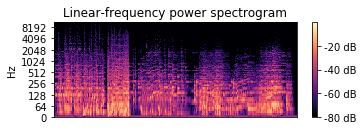

In [40]:
plt.figure(figsize=(12, 8))

D = lb.amplitude_to_db(np.abs(lb.stft(y)), ref=np.max)
plt.subplot(4, 2, 1)
lb.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

In [41]:
D.shape

(1025, 19585)

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

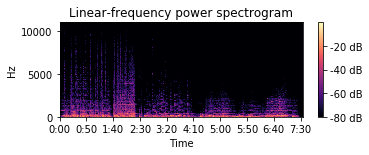

In [11]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 2, 1)
lb.display.specshow(D, y_axis='linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [42]:
len = math.ceil(lb.get_duration(y=y, sr=sr))

In [ ]:
fig = plt.figure(frameon=False)
fig.set_size_inches(len,20)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

lb.display.specshow(D, sr = 44100, cmap = 'gray_r', y_axis='linear', x_axis='time')
plt.savefig('one',bbox_inches='tight',transparent=False, pad_inches=0)

In [25]:
import image_slicer

In [44]:
image_slicer.slice('one.png', math.floor(len/20))

(<Tile #1 - one_01_01.png>,
 <Tile #2 - one_01_02.png>,
 <Tile #3 - one_01_03.png>,
 <Tile #4 - one_01_04.png>,
 <Tile #5 - one_02_01.png>,
 <Tile #6 - one_02_02.png>,
 <Tile #7 - one_02_03.png>,
 <Tile #8 - one_02_04.png>,
 <Tile #9 - one_03_01.png>,
 <Tile #10 - one_03_02.png>,
 <Tile #11 - one_03_03.png>,
 <Tile #12 - one_03_04.png>)

The single spectrogram that i have obtained here has takes 8.4 MB of storage and approxiamtely 30 seconds to be generated. This is simply too much. We need a more efficient way to turn music into spectrograms. This could be done by loweing the sampling rate and creating a time window and looping through the whole audio, but looking for an easier way to do so, we came across sox, the same tool that was used in the source code of the base article.

I had to convert my library to mp3, because sox does not work with m4a or flac files

In [3]:
import os
import subprocess

In [4]:
rootdir = ''

In [9]:
#source : https://stackoverflow.com/questions/19587118/iterating-through-directories-with-python

for subdir, dirs, files in os.walk(rootdir):
    index = 0
    for file in files:
        index += 1
        if file.endswith(".flac") or file.endswith(".m4a"):
            strf =  subdir + "/\"" + file + "\"" + " -vn -ar 44100 -ac 1 " + subdir + "/" + str(index) + ".mp3"
            os.system('ffmpeg -i ' + strf)
            os.remove(os.path.join(subdir, file))

In [10]:
# According to the command and parameters used in the base article and its source code

for subdir, dirs, files in os.walk(rootdir):
    index = 0
    for file in files:
        index += 1
        if file.endswith(".mp3"):
            strf = subdir + "/" + file + " -n spectrogram -X 50 -Y 200 -m -r -o " + subdir + "/" + str(index) + ".png"
            os.system('sox ' + strf)
            os.remove(os.path.join(subdir, file))

In [11]:
from PIL import Image

In [12]:
#source: https://stackoverflow.com/questions/6444548/how-do-i-get-the-picture-size-with-pil
#source: https://www.reddit.com/r/learnpython/comments/2jlv1e/python_script_to_take_an_image_and_cut_it_into_4/

for subdir, dirs, files in os.walk(rootdir):
    index = 0
    for file in files:
        index += 1
        if file.endswith(".png"):
            im = Image.open(subdir + "/" + file)
            width, height = im.size
            str_command = "convert %s -crop %ix1@ +repage +adjoin -resize 128x128 %s_%%02d.png" % (subdir + "/" + file, math.floor(width/128.0), subdir + "/" + str(index))
            os.system(str_command)
            os.remove(os.path.join(subdir, file))

Now we have to load the images into numpy arrays and tag them

In [34]:
#source: https://stackoverflow.com/questions/973473/getting-a-list-of-all-subdirectories-in-the-current-directory
#, https://stackoverflow.com/questions/5137497/find-current-directory-and-files-directory
#, https://stackoverflow.com/questions/35751306/python-how-to-pad-numpy-array-with-zeros

dataset_x = []
dataset_y = []
dirs = [o[1] for o in os.walk(rootdir)]
print(dirs)

for subdir, dirs, files in os.walk(rootdir):
    index = 0
    for file in files:
        index += 1
        if file.endswith(".png"):
            im = Image.open(subdir + "/" + file)
            width, height = im.size
            w = width - 128
            h = height - 128
            i = np.array(im)
            if h < 0 or w < 0:
                re = np.zeros((128,128))
                re[np.abs(h):,np.abs(w):] = i
                i = re
            dataset_x.append(i)
            dataset_y.append(os.path.basename(subdir))

[['Pop', 'Classical', 'Rock'], [], [], []]


In [98]:
for i, l in enumerate(dataset_y):
    if l == "Classical":
        dataset_y[i] = 0
    elif l == "Pop":
        dataset_y[i] = 1
    elif l == "Rock":
        dataset_y[i] = 2

In [99]:
#source https://stackoverflow.com/questions/27516849/how-to-convert-list-of-numpy-arrays-into-single-numpy-array

D = np.vstack(dataset_x)

In [100]:
D /= 255

In [101]:
H = D.reshape(len(dataset_x), 128, 128, 1)

In [102]:
H[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.89019608],
        [0.87058824],
        [0.85490196],
        ...,
        [0.6745098 ],
        [0.83921569],
        [0.86666667]],

       [[0.85882353],
        [0.85490196],
        [0.83529412],
        ...,
        [0.6627451 ],
        [0.85490196],
        [0.88235294]],

       [[0.80392157],
        [0.77647059],
        [0.78823529],
        ...,
        [0.63137255],
        [0.84313725],
        [0.8627451 ]]])

In [103]:
H[0].dtype

dtype('float64')

In [104]:
from sklearn.model_selection import train_test_split

In [105]:
#source: https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

x_train, x_test, y_train, y_test = train_test_split(H, dataset_y, test_size=0.2, random_state=1023)

In [106]:
x_train[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.7372549 ],
        [0.72941176],
        [0.71764706],
        ...,
        [0.78823529],
        [0.77254902],
        [0.76862745]],

       [[0.74901961],
        [0.72941176],
        [0.7372549 ],
        ...,
        [0.71764706],
        [0.67843137],
        [0.72941176]],

       [[0.70196078],
        [0.66666667],
        [0.70588235],
        ...,
        [0.6627451 ],
        [0.61960784],
        [0.71372549]]])

In [107]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [128]:
batch_size = 128
num_classes = 3
epochs = 20

In [109]:
img_rows, img_cols = 128, 128

In [110]:
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)

In [116]:
input_shape

(128, 128, 1)

In [111]:
x_train[0].shape

(128, 128, 1)

In [112]:
input_shape

(128, 128, 1)

In [113]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (8185, 128, 128, 1)
8185 train samples
2047 test samples


In [114]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [126]:
# Based on the original article's source code

model = Sequential()
model.add(Conv2D(64, kernel_size=(2, 2),
                 activation='elu',
                 input_shape=input_shape))


model.add(Conv2D(64, (2, 2), activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (2, 2), activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (2, 2), activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (2, 2), activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 8185 samples, validate on 2047 samples
Epoch 1/20
1152/8185 [===>..........................] - ETA: 13:36 - loss: 10.6796 - acc: 0.3325

## Conclusion:
It takes a lot of time to train the network, and about 2000 songs are needed to achieve an accuracy of 80%. Data was purposefully split into train and test instead of train, validation and test to increase the number of training samples.

## Version History

* June 2018 - Project Created
* December 2019 - Project Updated